# Import Data

In [1]:
import numpy as np
np.random.seed(1248)
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [4]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [5]:
x = pd.read_csv("../data/buffer_overflow_graph_embeddings.csv.gz")
x['testcase_ID'] = x['type']
del x['type']
x = x.sort_values("testcase_ID").reset_index(drop=True)

In [6]:
y = labels['bug']
x = x.drop('testcase_ID', axis='columns')

In [7]:
import pickle

with open('../data/x-train-binary','rb') as f:
    x_train = pickle.load(f)
    
with open('../data/y-train-binary','rb') as f:
    y_train = pickle.load(f)
    
with open('../data/x-test-binary','rb') as f:
    x_test = pickle.load(f)
    
with open('../data/y-test-binary','rb') as f:
    y_test = pickle.load(f)

In [8]:
y_train.shape

(17201,)

In [9]:
x_train.shape

(17201, 128)

# Baseline Neural Network

In [9]:
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, Conv2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.layers import RepeatVector, Permute, Lambda, ActivityRegularization, AveragePooling1D
from keras.optimizers import Nadam, Adagrad
import math

In [10]:
import pickle

with open('../data/dense-model-binary','rb') as f:
    model = pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 65us/step


[0.09569287468142022, 0.9537316903184386]

In [20]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [18]:
y_predict= model.predict(x_test)

In [19]:
import numpy as np

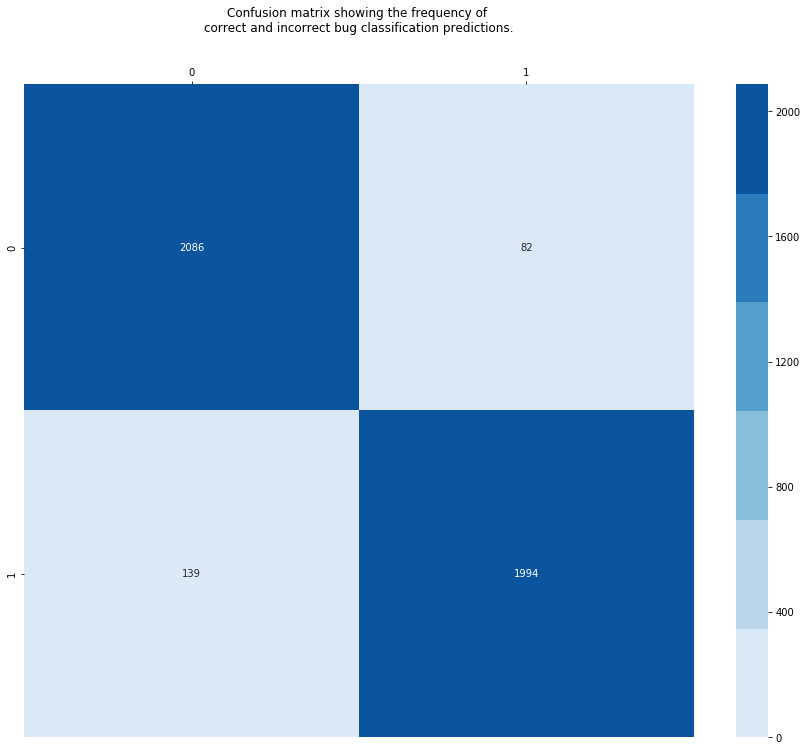

In [20]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(15, 12)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

# Convolutional Neural Network

The functions below can be used as Neural Network layers if we want.

In [15]:
#What is K?

def antirectifier(x):
    x -= K.mean(x, axis=1, keepdims=True)
    x = K.l2_normalize(x, axis=1)
    pos = K.relu(x)
    neg = K.relu(-x)
    return K.concatenate([pos, neg], axis=1)

def antirectifier_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2  # only valid for 2D tensors
    shape[-1] *= 2
    return tuple(shape)

#conv_model.add(Lambda(antirectifier,output_shape=antirectifier_output_shape))


def hadamard_product_sum(tensors):
    out1 = tensors[0] * tensors[1]
    out2 = K.sum(out1, axis=-1)
    return [out1, out2]

def hadamard_product_sum_output_shape(input_shapes):
    shape1 = list(input_shapes[0])
    shape2 = list(input_shapes[1])
    assert shape1 == shape2  # else hadamard product isn't possible
    return [tuple(shape1), tuple(shape2[:-1])]

#conv_model(Lambda(hadamard_product_sum, hadamard_product_sum_output_shape))

Because our input is not the right dimension to go straight into a neural network, it makes sense to start with a dense layer that our data can be inputted into with ease. In order to get the data into the right dimensions the RepeatVector function is used. Reshape would have been ideal but the NN did not like this and would always error. Using Repeat Vector may not keep the proper structure we want.
A 1D convolutional layer is added. This moves along one axis as it convolutes. Strides is how far it moves each time and to just move one step yielded the best results. Sigmoid worked best as an activation because it is a logistic function so works well for our binary data. I have then used the dropout function to lower our chance of overfitting. It sets, at rate 0.5, input units to 0 at each update during training time. Then we pool using padding as 'same' so everything is padded to the same length here. Then flattening it back to 2 dimensions.
Adding in squaring everything helped for predictions as values close to 1 got closer and those close to 0 got closer. Then from tutorials it always seemed a good idea to finish with dense.

In [12]:
conv_model = Sequential()

conv_model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
conv_model.add(RepeatVector(3))


# conv_model.add(Lambda(lambda x: x ** 3))

# conv_model.add(Permute(2,1))

conv_model.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, activation ='sigmoid'))
conv_model.add(Dropout(0.5))
conv_model.add(MaxPooling1D(pool_size = 2, padding = 'same'))
# conv_model.add(Conv1D(filters = 64, kernel_size = 3, activation ='linear'))
# conv_model.add(LeakyReLU(alpha=0.1))
# conv_model.add(MaxPooling1D(pool_size = 2, padding = 'same'))
conv_model.add(Flatten())

conv_model.add(Lambda(lambda x: x**2))

conv_model.add(Dense(128, activation='sigmoid'))
# conv_model.add(LeakyReLU(alpha=0.1))
conv_model.add(Dropout(0.05))

conv_model.add(Dense(units=1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             24640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64)                0         
__________

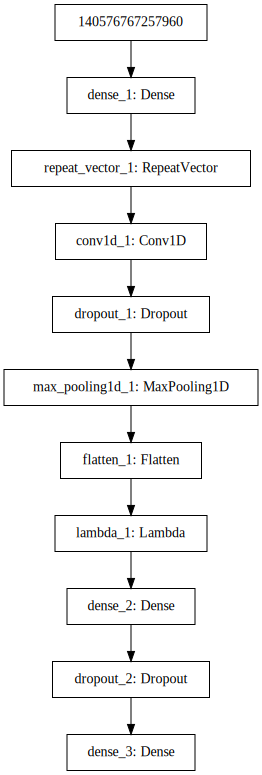

In [14]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return model_to_dot(model).create(prog='dot', format='svg')

model_diagram = visualize_model(conv_model)

with open('../images/graph2vec-architecture-cnn.svg', 'wb') as f:
    f.write(model_diagram)

SVG(model_diagram)

In [13]:
conv_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])
conv_model.fit(x_train, y_train, epochs=50, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
17201/17201 [==============================] - 2s 99us/step - loss: 0.6944 - acc: 0.5202
Epoch 2/50
17201/17201 [==============================] - 1s 66us/step - loss: 0.6234 - acc: 0.6510
Epoch 3/50
17201/17201 [==============================] - 2s 104us/step - loss: 0.5323 - acc: 0.7291
Epoch 4/50
17201/17201 [==============================] - 1s 73us/step - loss: 0.4667 - acc: 0.7731
Epoch 5/50
17201/17201 [==============================] - 2s 106us/step - loss: 0.3932 - acc: 0.8136
Epoch 6/50
17201/17201 [==============================] - 1s 78us/step - loss: 0.3282 - acc: 0.8457
Epoch 7/50
17201/17201 [==============================] - 1s 85us/step - loss: 0.2685 - acc: 0.8739
Epoch 8/50
17201/17201 [==============================] - 1s 83us/step - loss: 0.2210 - acc: 0.8968
Epoch 9/50
17201/17201 [==============================] - 1s 65us/step - loss: 0.1919 - acc: 0.9119
Epoch 10/50
17201/17201 [=========================

In [14]:
conv_model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 57us/step


[0.09828291945653138, 0.9502441292722623]

In [26]:
import pickle

with open('../data/binary-convolutional','wb') as f:
    pickle.dump(conv_model,f)

In [27]:
y_predict_conv= conv_model.predict(x_test)

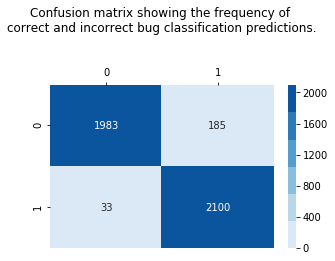

In [29]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict_conv)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [30]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict_conv)).flatten().tolist()

fpr_cnn = fp/(fp+tp)
fnr_cnn = fn/(fn+tn)

In [31]:
fpr_cnn

0.08096280087527352

In [32]:
fnr_cnn

0.01636904761904762

In [36]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve((y_test.values+0), y_predict_conv)

In [37]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

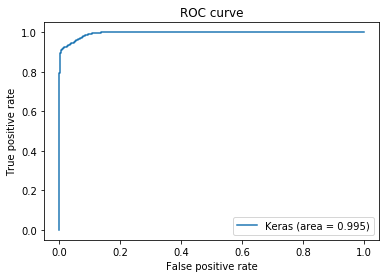

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('../images/baseline_roc_curve')

### Train / Test / Val Split

In [15]:
with open('../data/x-train-binary-for-3-way-split','rb') as f:
    x_train1 = pickle.load(f)
    
with open('../data/y-train-binary-for-3-way-split','rb') as f:
    y_train1 = pickle.load(f)
    
with open('../data/x-val-binary','rb') as f:
    x_val = pickle.load(f)
    
with open('../data/y-val-binary','rb') as f:
    y_val = pickle.load(f)

In [16]:
conv_model.fit(x_train1, y_train1, validation_data = (x_val, y_val), epochs=50, batch_size=64)

Train on 15050 samples, validate on 2151 samples
Epoch 1/50
15050/15050 [==============================] - 1s 72us/step - loss: 0.0885 - acc: 0.9540 - val_loss: 0.0894 - val_acc: 0.9512
Epoch 2/50
15050/15050 [==============================] - 1s 91us/step - loss: 0.0904 - acc: 0.9506 - val_loss: 0.1336 - val_acc: 0.9433
Epoch 3/50
15050/15050 [==============================] - ETA: 0s - loss: 0.0883 - acc: 0.952 - 3s 172us/step - loss: 0.0883 - acc: 0.9528 - val_loss: 0.0872 - val_acc: 0.9572
Epoch 4/50
15050/15050 [==============================] - 1s 96us/step - loss: 0.0888 - acc: 0.9526 - val_loss: 0.0863 - val_acc: 0.9563
Epoch 5/50
15050/15050 [==============================] - 1s 89us/step - loss: 0.0868 - acc: 0.9550 - val_loss: 0.0845 - val_acc: 0.9558
Epoch 6/50
15050/15050 [==============================] - 1s 72us/step - loss: 0.0889 - acc: 0.9542 - val_loss: 0.0899 - val_acc: 0.9572
Epoch 7/50
15050/15050 [==============================] - 1s 74us/step - loss: 0.0858 - ac

In [17]:
conv_model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 74us/step


[0.09072386094565392, 0.9530341781258334]

In [18]:
y_predict_conv1= conv_model.predict(x_test)

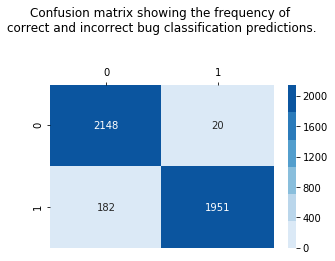

In [21]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict_conv1)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [22]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict_conv1)).flatten().tolist()

fpr_cnn1 = fp/(fp+tp)
fnr_cnn1 = fn/(fn+tn)

In [23]:
fpr_cnn1

0.010147133434804667

In [24]:
fnr_cnn1

0.07811158798283262